# The Price is Right

## Finishing off with Random Forests, XG Boost & Ensemble

In [2]:
!pip install xgboost

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import xgboost as xgb

In [2]:
# CONSTANTS

DB = "products_vectorstore"

In [3]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)
    
# training data is already in Chroma

In [5]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [6]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest

We will now train a Random Forest model.

Can you spot the difference from what we did in Week 6? In week 6 we used the word2vec model to form vectors; this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [8]:
# This next line takes an hour on my M1 Mac!

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

RandomForestRegressor(n_jobs=-1, random_state=42)

n_job = -1 means it is using every core

In [11]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [12]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

# XG Boost Model

In [7]:
train_dmatrix = xgb.DMatrix(vectors, label=prices)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "learning_rate": 0.1,
    "nthread": -1,
    "verbosity": 1,
    "subsample": 0.8,
}

model = xgb.train(params, train_dmatrix, num_boost_round=100)

In [8]:
joblib.dump(model,'xg_boost_model.pkl')

['xg_boost_model.pkl']

In [9]:
xgb_model = joblib.load('xg_boost_model.pkl')

# Agents

In [10]:
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent
from agents.xg_boost_agent import XGBoostAgent

In [11]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()
xg_boost = XGBoostAgent()

C:\Users\92310\anaconda3\envs\llms\Lib\asyncio\events.py:84: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)


In [12]:
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [16]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $188.72 Truth: $32.70 Error: $156.02 SLE: 2.99 Item: AXE HEAVEN Stranger Things Eddie's Guita...
2: Guess: $116.36 Truth: $213.94 Error: $97.58 SLE: 0.37 Item: Southbend Range 1175016 Natural Gas Valv...
3: Guess: $90.60 Truth: $79.99 Error: $10.61 SLE: 0.02 Item: SUNY Party Lights DJ Stage Lighting 12 G...
4: Guess: $40.98 Truth: $18.99 Error: $21.99 SLE: 0.55 Item: 113PCS Birthday Party Supplies and Decor...
5: Guess: $233.06 Truth: $44.95 Error: $188.11 SLE: 2.65 Item: Artist Unknown A- B Box, Black (T-LPSMR ...
6: Guess: $88.22 Truth: $84.99 Error: $3.23 SLE: 0.00 Item: PINK Child’s Practice Chanter by R.G.Har...
7: Guess: $93.69 Truth: $592.95 Error: $499.26 SLE: 3.37 Item: PENNZONI 4ft Drum Shield w/Deflectors & ...
8: Guess: $123.40 Truth: $325.01 Error: $201.61 SLE: 0.93 Item: LEGO Bionicle Umarak The Destroyer (7131...
9: Guess: $104.34 Truth: $90.99 Error: $13.35 SLE: 0.02 Item: (Red) - Hape E3153 Toy, Multicolor
10: Guess: $45.67 Truth: $52.39 Error: $6.72 SLE: 0.0

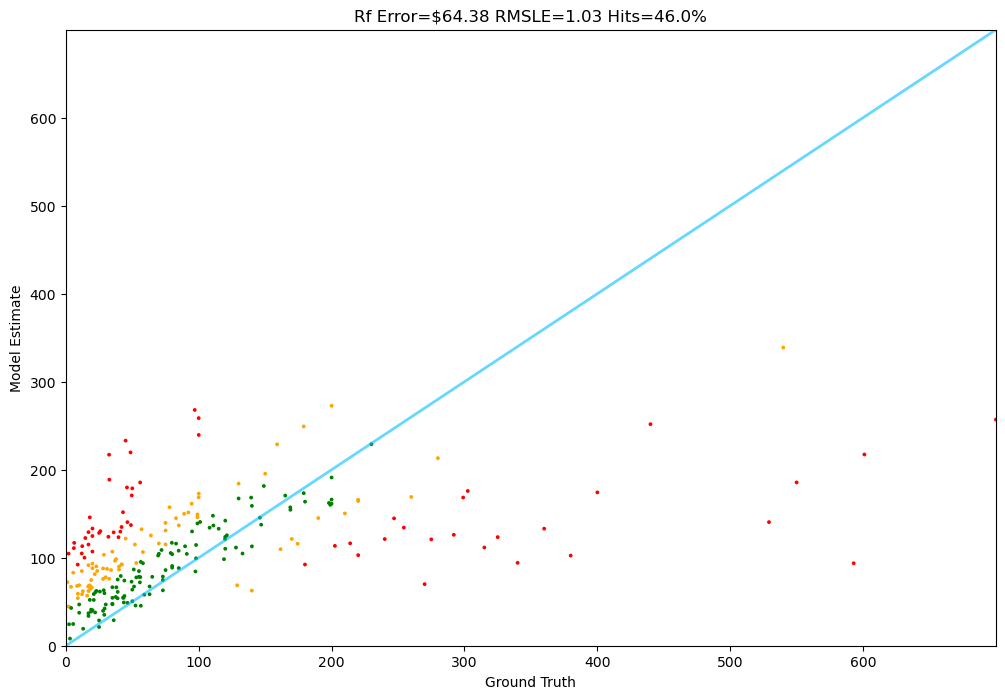

In [17]:
Tester.test(rf, test)

In [14]:
def xg_b(item):
    return xg_boost.price(description(item))

In [15]:
xg_b(test[0])

216.84239

1: Guess: $216.84 Truth: $32.70 Error: $184.14 SLE: 3.48 Item: AXE HEAVEN Stranger Things Eddie's Guita...
2: Guess: $128.56 Truth: $213.94 Error: $85.38 SLE: 0.26 Item: Southbend Range 1175016 Natural Gas Valv...
3: Guess: $62.34 Truth: $79.99 Error: $17.65 SLE: 0.06 Item: SUNY Party Lights DJ Stage Lighting 12 G...
4: Guess: $26.43 Truth: $18.99 Error: $7.44 SLE: 0.10 Item: 113PCS Birthday Party Supplies and Decor...
5: Guess: $205.67 Truth: $44.95 Error: $160.72 SLE: 2.26 Item: Artist Unknown A- B Box, Black (T-LPSMR ...
6: Guess: $64.13 Truth: $84.99 Error: $20.86 SLE: 0.08 Item: PINK Child’s Practice Chanter by R.G.Har...
7: Guess: $69.80 Truth: $592.95 Error: $523.15 SLE: 4.52 Item: PENNZONI 4ft Drum Shield w/Deflectors & ...
8: Guess: $118.38 Truth: $325.01 Error: $206.63 SLE: 1.01 Item: LEGO Bionicle Umarak The Destroyer (7131...
9: Guess: $65.93 Truth: $90.99 Error: $25.06 SLE: 0.10 Item: (Red) - Hape E3153 Toy, Multicolor
10: Guess: $66.06 Truth: $52.39 Error: $13.67 SLE: 0.0

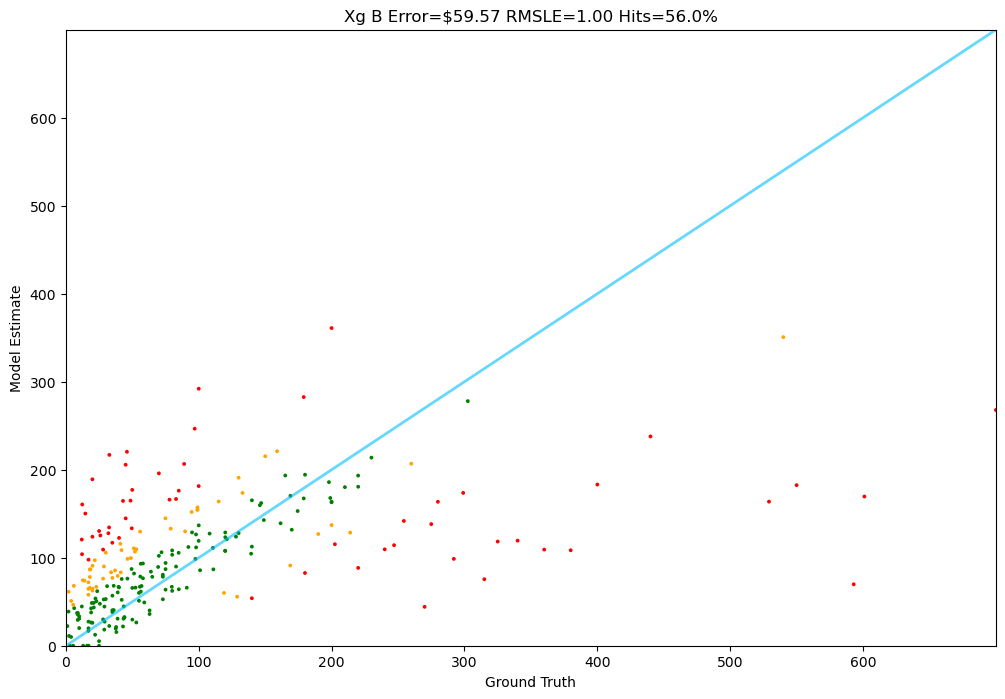

In [16]:
Tester.test(xg_b, test)

# Moving towards the ensemble model

In [18]:
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [19]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))
print(xg_boost.price(product))

150.0
139.99
193.3397000000001
208.99522


In [21]:
specialists = []
frontiers = []
random_forests = []
xg_boosts = []
prices = []

for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    xg_boosts.append(xg_boost.price(text))
    prices.append(item.price)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [14:22<00:00,  3.45s/it]


In [23]:
mins = [min(s,f,r,x) for s,f,r,x in zip(specialists, frontiers, random_forests, xg_boosts)]
maxes = [max(s,f,r,x) for s,f,r,x in zip(specialists, frontiers, random_forests, xg_boosts)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'XGBoost' : xg_boosts,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [24]:
# Train a Linear Regression - current
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.25
Frontier: 0.41
RandomForest: -0.21
XGBoost: -0.28
Min: 0.69
Max: 0.25
Intercept=17.02


In [30]:
# Train a Linear Regression - old vals w/o xg
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.39
Frontier: 0.54
RandomForest: -0.20
Min: 0.27
Max: 0.03
Intercept=17.26


In [25]:
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [26]:
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

C:\Users\92310\anaconda3\envs\llms\Lib\asyncio\events.py:84: DeprecationError: 2025-01-27: `modal.Cls.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Cls.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)


In [26]:
ensemble.price(product) #old val

158.23674746407366

In [27]:
ensemble.price(product)

161.80814036965486

In [28]:
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $41.09 Truth: $32.70 Error: $8.39 SLE: 0.05 Item: AXE HEAVEN Stranger Things Eddie's Guita...
2: Guess: $119.92 Truth: $213.94 Error: $94.02 SLE: 0.33 Item: Southbend Range 1175016 Natural Gas Valv...
3: Guess: $66.59 Truth: $79.99 Error: $13.40 SLE: 0.03 Item: SUNY Party Lights DJ Stage Lighting 12 G...
4: Guess: $39.05 Truth: $18.99 Error: $20.06 SLE: 0.48 Item: 113PCS Birthday Party Supplies and Decor...
5: Guess: $51.55 Truth: $44.95 Error: $6.60 SLE: 0.02 Item: Artist Unknown A- B Box, Black (T-LPSMR ...
6: Guess: $82.03 Truth: $84.99 Error: $2.96 SLE: 0.00 Item: PINK Child’s Practice Chanter by R.G.Har...
7: Guess: $400.21 Truth: $592.95 Error: $192.74 SLE: 0.15 Item: PENNZONI 4ft Drum Shield w/Deflectors & ...
8: Guess: $101.05 Truth: $325.01 Error: $223.96 SLE: 1.35 Item: LEGO Bionicle Umarak The Destroyer (7131...
9: Guess: $116.59 Truth: $90.99 Error: $25.60 SLE: 0.06 Item: (Red) - Hape E3153 Toy, Multicolor
10: Guess: $99.74 Truth: $52.39 Error: $47.35 SLE: 0.40 It

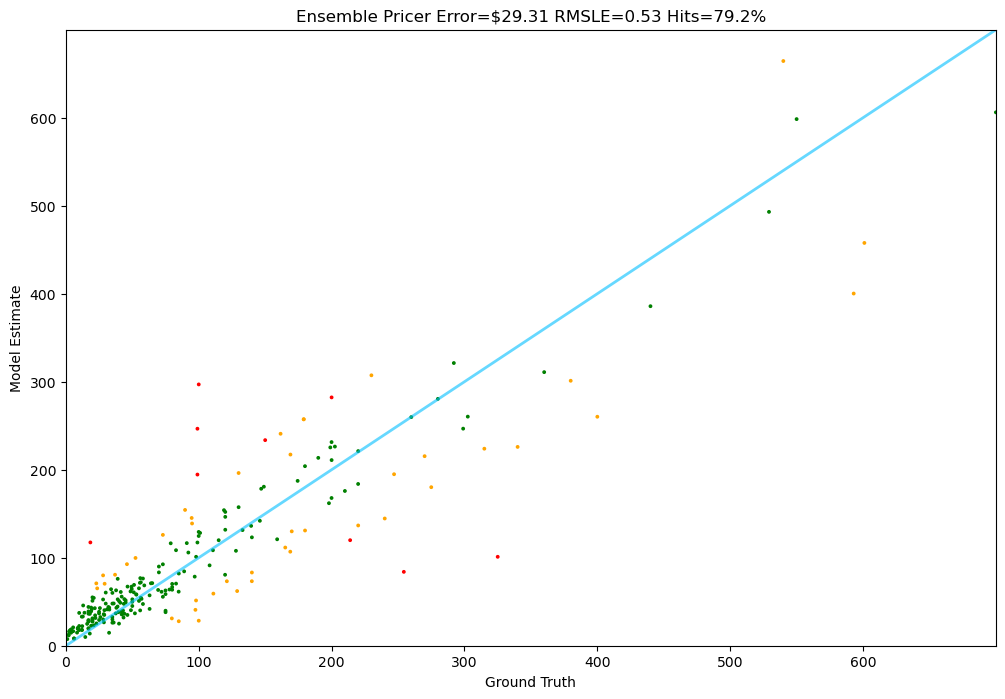

In [32]:
Tester.test(ensemble_pricer, test) #old 

1: Guess: $22.95 Truth: $32.70 Error: $9.75 SLE: 0.12 Item: AXE HEAVEN Stranger Things Eddie's Guita...
2: Guess: $116.05 Truth: $213.94 Error: $97.89 SLE: 0.37 Item: Southbend Range 1175016 Natural Gas Valv...
3: Guess: $73.23 Truth: $79.99 Error: $6.76 SLE: 0.01 Item: SUNY Party Lights DJ Stage Lighting 12 G...
4: Guess: $42.82 Truth: $18.99 Error: $23.83 SLE: 0.62 Item: 113PCS Birthday Party Supplies and Decor...
5: Guess: $49.75 Truth: $44.95 Error: $4.80 SLE: 0.01 Item: Artist Unknown A- B Box, Black (T-LPSMR ...
6: Guess: $86.15 Truth: $84.99 Error: $1.16 SLE: 0.00 Item: PINK Child’s Practice Chanter by R.G.Har...
7: Guess: $396.52 Truth: $592.95 Error: $196.43 SLE: 0.16 Item: PENNZONI 4ft Drum Shield w/Deflectors & ...
8: Guess: $98.95 Truth: $325.01 Error: $226.06 SLE: 1.40 Item: LEGO Bionicle Umarak The Destroyer (7131...
9: Guess: $114.12 Truth: $90.99 Error: $23.13 SLE: 0.05 Item: (Red) - Hape E3153 Toy, Multicolor
10: Guess: $100.00 Truth: $52.39 Error: $47.61 SLE: 0.41 Ite

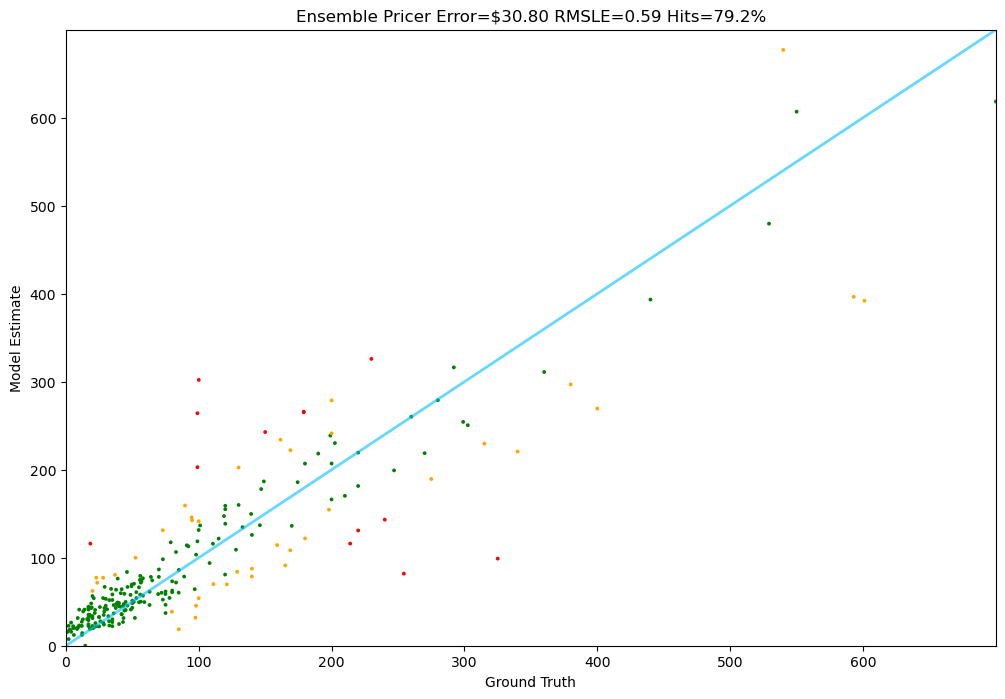

In [29]:
Tester.test(ensemble_pricer, test)